# Import Depedencies

In [ ]:
!pip install split-folders

In [ ]:
import os
import cv2
import numpy as np
import splitfolders
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

# See Image Sample

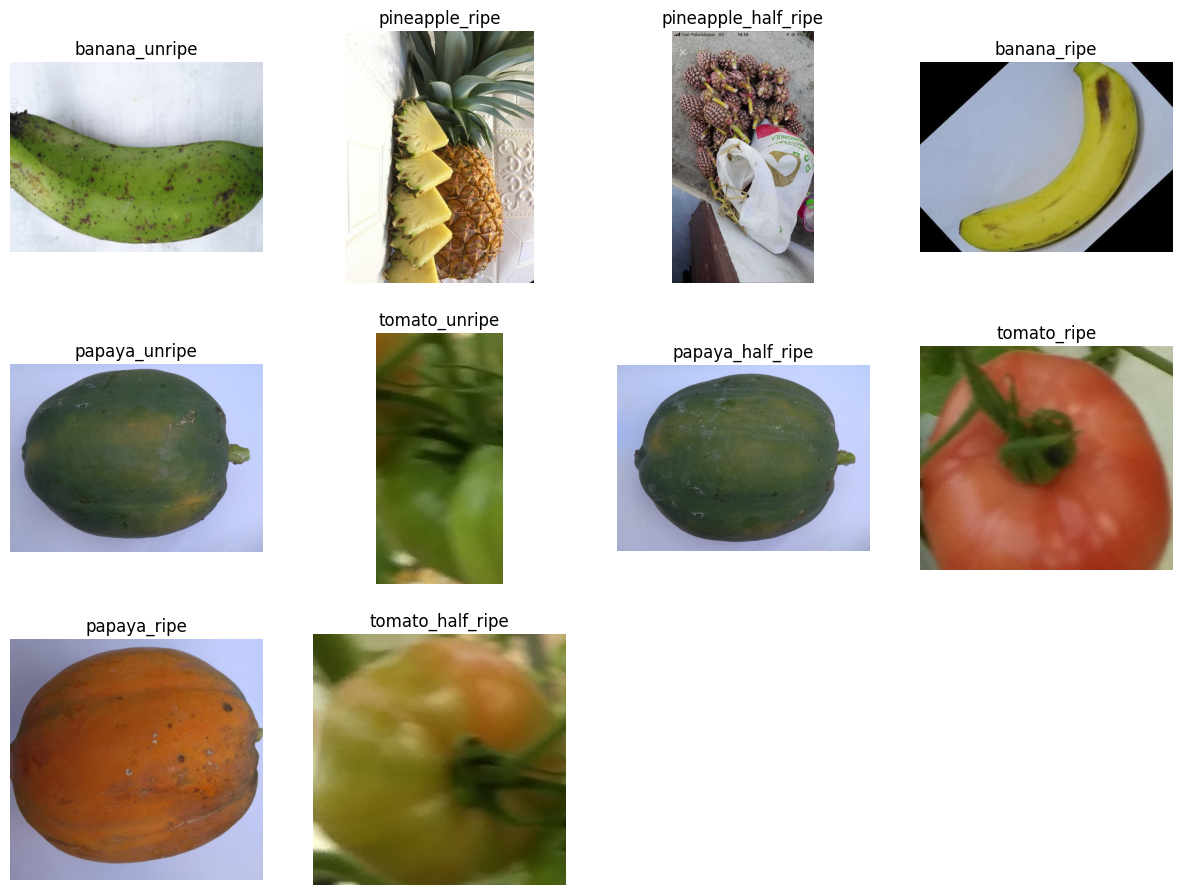

In [ ]:
fig = plt.figure(figsize=(15,15))

image_folder = "./buah/"
for index, label in enumerate(os.listdir(image_folder)):
  img = os.listdir(os.path.join(image_folder,label))[0]
  img = cv2.imread(image_folder+"/"+label+"/"+img)

  fig.add_subplot(4, 4, index+1)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title(label)
  plt.axis("off")
plt.show()

# Split Into training and Testing

In [ ]:
splitfolders.ratio(
  "/content/buah",
  output="./buah_dataset/",
  ratio=(.9, .1,),
  group_prefix=None,
  move=False
)

Copying files: 4935 files [00:01, 3150.11 files/s]


# Generator

In [ ]:
train = "/content/buah_dataset/train"
val = "/content/buah_dataset/val"

In [ ]:
train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rescale=(1/255.)
    )
train_generator = train_datagen.flow_from_directory(
        directory=train,
        batch_size=32,
        class_mode='categorical',
        target_size=(160,160)
    )


val_datagen = ImageDataGenerator(
        rescale=(1/255)
    )
val_generator = val_datagen.flow_from_directory(
        directory=val,
        batch_size=32,
        class_mode='categorical',
        target_size=(160,160)
    )

Found 4439 images belonging to 10 classes.
Found 496 images belonging to 10 classes.


In [ ]:
#make classes dictionary
classes = sorted(os.listdir("buah_dataset/val"))
classes_dict = {key:classes[key] for key in range(len(classes))}
classes_dict

{0: 'banana_ripe',
 1: 'banana_unripe',
 2: 'papaya_half_ripe',
 3: 'papaya_ripe',
 4: 'papaya_unripe',
 5: 'pineapple_half_ripe',
 6: 'pineapple_ripe',
 7: 'tomato_half_ripe',
 8: 'tomato_ripe',
 9: 'tomato_unripe'}

# Model

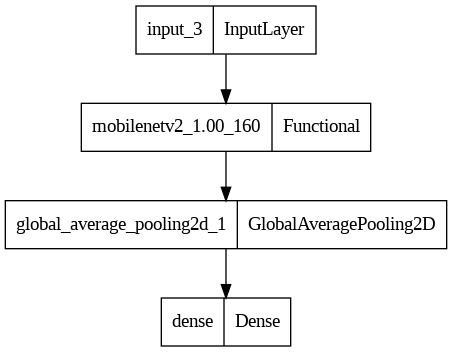

In [ ]:
output_activation = 'softmax' if len(classes) > 2 else 'sigmoid'

# Import pre-trained model (MobileNetV2)
IMG_SHAPE = (160,160,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# Freezing
for layer in base_model.layers:
  layer.trainable = False

# Make classifier layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
output_layer = tf.keras.layers.Dense(len(classes_dict), activation=output_activation)


inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = global_average_layer(x)
outputs = output_layer(x)
model = tf.keras.Model(inputs, outputs)

tf.keras.utils.plot_model(model=model)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cp = tf.keras.callbacks.ModelCheckpoint(
    "buah.h5",
    monitor = 'val_loss',
    save_best_only=True,
    verbose=1
)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
)

In [ ]:
history = model.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[cp,es])

Epoch 1/100
139/139 [==============================] - ETA: 0s - loss: 0.1115 - accuracy: 0.9597
Epoch 1: val_loss improved from inf to 0.21862, saving model to buah.h5
139/139 [==============================] - 24s 171ms/step - loss: 0.1115 - accuracy: 0.9597 - val_loss: 0.2186 - val_accuracy: 0.9133
Epoch 2/100
139/139 [==============================] - ETA: 0s - loss: 0.1074 - accuracy: 0.9590
Epoch 2: val_loss improved from 0.21862 to 0.19609, saving model to buah.h5
139/139 [==============================] - 23s 164ms/step - loss: 0.1074 - accuracy: 0.9590 - val_loss: 0.1961 - val_accuracy: 0.9194
Epoch 3/100
139/139 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.9581
Epoch 3: val_loss improved from 0.19609 to 0.19276, saving model to buah.h5
139/139 [==============================] - 22s 159ms/step - loss: 0.1140 - accuracy: 0.9581 - val_loss: 0.1928 - val_accuracy: 0.9214
Epoch 4/100
139/139 [==============================] - ETA: 0s - loss: 0.1038 - acc

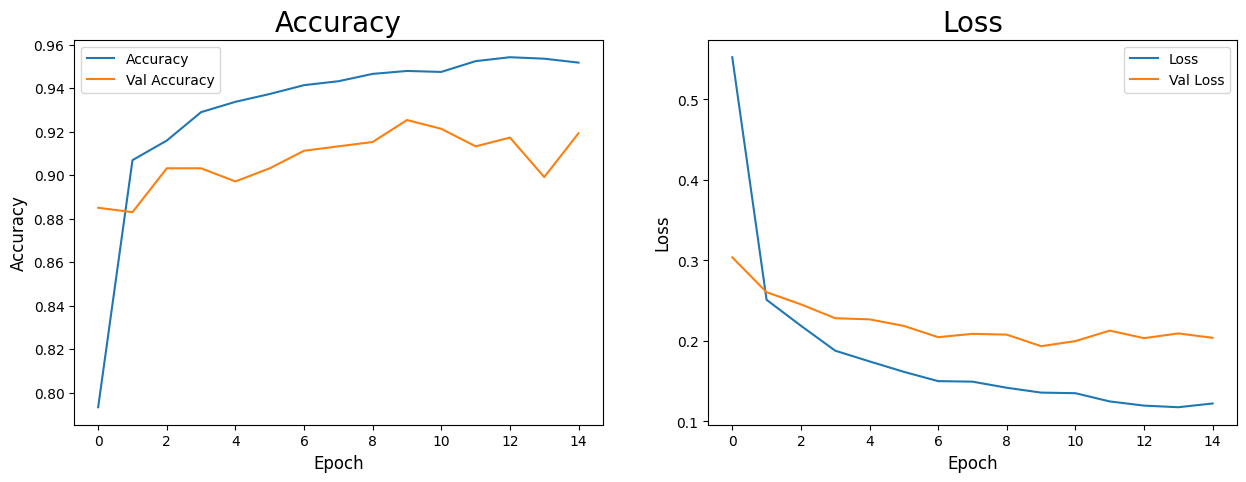

In [ ]:
fig, (axs1, axs2) = plt.subplots(1,2, figsize=(15,5))
axs1.plot(history.history['accuracy'])
axs1.plot(history.history['val_accuracy'])
axs1.legend(['Accuracy','Val Accuracy'])
axs1.set_xlabel('Epoch', fontsize=12)
axs1.set_ylabel('Accuracy', fontsize=12)
axs1.set_title('Accuracy', fontsize=20)

axs2.plot(history.history['loss'])
axs2.plot(history.history['val_loss'])
axs2.legend(['Loss','Val Loss'])
axs2.set_xlabel('Epoch', fontsize=12)
axs2.set_ylabel('Loss', fontsize=12)
axs2.set_title('Loss', fontsize=20)
plt.show()